In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text

In [2]:
PLOT_DPI = 150  
sns.set_style('whitegrid', {'axes.facecolor': '0.98', 'grid.color': '0.9', 'axes.edgecolor': '1.0'})
plt.rc(
       'axes',
       labelweight='bold',
       titlesize=16,
       titlepad=10,
      )

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [3]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [4]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [5]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [6]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [7]:
# напишите запрос
query1 = '''
 SELECT DATE_TRUNC('month', creation_date) AS month_date,
        SUM(views_count) AS total_views
FROM stackoverflow.posts
GROUP BY DATE_TRUNC('month', creation_date)
ORDER BY total_views DESC;
'''

sample_df1 = pd.read_sql_query(query1, con=engine) # выполните запрос

In [8]:
sample_df1

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


<details>

<summary>Подсказка</summary>
Используйте функцию для усечения даты, а затем сгруппируйте и отсортируйте данные.
</details>

Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

Максимальное количество просмотров - сентябрь и октябрь. Вероятно, студенты начинают учебные курсы и активно ищут информацию. Июль резкое снижение показателя - возможно в базе данные не за полный месяц.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [9]:
# напишите запрос
query2 = '''
SELECT DISTINCT display_name,
       COUNT(id) OVER(PARTITION BY display_name)
FROM
(SELECT DISTINCT u.id AS id,
       u.display_name AS display_name,
       COUNT(p.id) OVER(PARTITION BY u.display_name) AS count_p
FROM stackoverflow.posts AS p
JOIN stackoverflow.users AS u ON u.id=p.user_id
JOIN stackoverflow.post_types AS pt ON p.post_type_id=pt.id
WHERE pt.type = 'Answer' AND p.creation_date::date BETWEEN u.creation_date::date AND
                                               u.creation_date::date + INTERVAL '1 month'
ORDER BY count_p DESC) AS pre_t
WHERE count_p>100
ORDER BY display_name
'''

sample_df2 = pd.read_sql_query(query2, con=engine)# выполните запрос


In [10]:
sample_df2.sort_values(by='count', ascending=False)

,display_name,count
45,Matt,29
10,Chris,29
14,Dan,21
64,Tom,19
41,Mark,17
...,...,...
38,Lasse Vågsæther Karlsen,1
1,Adam Bellaire,1
40,Marc Gravell,1
42,Mark Cidade,1


<details>

<summary>Подсказка</summary>
Вам нужно присоединить несколько таблиц — изучите внимательнее описание базы. Чтобы добавить промежуток времени к дате, используйте ключевое слово INTERVAL, например, так: <дата> + INTERVAL '1 year 2 months 3 days'
.</details>

Какие аномалии наблюдаются в данных? О чём они говорят?

Много пользователей регистрировались, указывая только имя. 

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [11]:
# напишите запрос
query3 = '''
SELECT DISTINCT DATE_TRUNC('month', creation_date) AS month,
       COUNT(id) OVER(PARTITION BY DATE_TRUNC('month', creation_date))
FROM stackoverflow.posts
WHERE user_id IN

(SELECT u.id AS id
FROM stackoverflow.users AS u
JOIN stackoverflow.posts AS p ON p.user_id = u.id
WHERE DATE_TRUNC('month', u.creation_date) = '2008-09-01' AND DATE_TRUNC('month', p.creation_date) = '2008-12-01')
ORDER BY month DESC


'''

sample_df3 = pd.read_sql_query(query3, con=engine)# выполните запрос

In [12]:
sample_df3

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


<details>

<summary>Подсказка</summary>
Сначала найдите идентификаторы пользователей, которые зарегистрировались в сентябре 2008 года и оставили хотя бы один пост в декабре. Затем используйте результат для среза и посчитайте посты по месяцам.</details>

Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

Сразу после регистрации люди редко сами оставляют посты, вначале просто читают, затем активность возрастает (в октябре максимум постов) и затем спадает. # напишите ваш ответ здесь

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [13]:
# напишите запрос
query4 = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER(PARTITION BY user_id ORDER BY id) AS cumulative_count
FROM stackoverflow.posts
ORDER BY user_id, creation_date

'''

sample_df4 = pd.read_sql_query(query4, con=engine)# выполните запрос

In [14]:
sample_df4

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


<details>

<summary>Подсказка</summary>
Для подсчёта суммы с накоплением используйте оконную функцию.
</details>

# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [15]:
# напишите запрос
query5 = '''
 WITH post_count AS
(SELECT user_id,
        creation_date::DATE,
        COUNT(id) AS post_count
FROM stackoverflow.posts
WHERE DATE_TRUNC('month', creation_date)::DATE = '2008-08-01'
GROUP BY user_id, creation_date::DATE)
SELECT user_id,
       AVG(post_count) AS avg_daily
FROM post_count
GROUP BY user_id
HAVING SUM(post_count) > 120
ORDER BY avg_daily

'''

sample_df5 = pd.read_sql_query(query5, con=engine)

In [16]:
sample_df5

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


<details>

<summary>Подсказка</summary>
Сначала найдите идентификаторы пользователей, которые написали более 120 постов за август. Используя этот запрос в качестве подзапроса для среза, найдите и сохраните во временную таблицу идентификаторы нужных пользователей, дни августа и количество постов в день. В основном запросе сгруппируйте данные по пользователям и найдите для каждого из них среднее количество постов.
</details>

# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [17]:
# напишите запрос
query6 = '''
SELECT CAST(AVG(count) AS INTEGER) AS result 
FROM
(SELECT user_id,
       COUNT(DISTINCT creation_date::DATE) AS count
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07'
GROUP BY user_id) AS pre_t
'''

sample_df6 = pd.read_sql_query(query6, con=engine)# выполните запрос

In [18]:
sample_df6

,result
0,2


<details>

<summary>Подсказка</summary>
Посчитайте, сколько активных дней было у каждого пользователя. Добавьте данные во временную таблицу и используйте в основном запросе.
</details>

Проанализируйте итоговую таблицу — какие выводы можно сделать?

В среднем пользователи делают посты в в течении 2 дней из 8.

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [19]:
# напишите запрос
query7 = '''
SELECT user_id,
       creation_date,
       LAG(TO_CHAR(creation_date, 'Month'), 2) OVER(PARTITION BY user_id ORDER BY creation_date)
FROM stackoverflow.posts
ORDER BY user_id, creation_date
'''

sample_df7 = pd.read_sql_query(query7, con=engine)# выполните запрос

In [20]:
sample_df7

,user_id,creation_date,lag
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


<details>

<summary>Подсказка</summary>
Преобразовать результат оконной функции в нужное значение вам поможет аналог условного оператора в SQL: CASE <поле> WHEN <старое значение> THEN <новое значение> END.
</details>

# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [21]:
# напишите запрос
query8 = '''
WITH cohort_init AS
        (SELECT DISTINCT user_id,
               FIRST_VALUE(DATE_TRUNC('month', creation_date)) OVER(PARTITION BY user_id ORDER BY creation_date) AS cohort_date
        FROM stackoverflow.posts),
        cohort_info AS(
        SELECT *,
              COUNT(user_id) OVER(PARTITION BY cohort_date) AS cohort_users_cnt
        FROM cohort_init
        ORDER BY cohort_date, user_id),
        acivity AS (
        SELECT user_id,
            DATE_TRUNC('month', creation_date) AS session_date
        FROM stackoverflow.posts
        GROUP BY user_id, DATE_TRUNC('month', creation_date)
        )
        
        
        SELECT
            cohort_date,
            session_date,
            COUNT(cohort_info.user_id),
            cohort_users_cnt,
            COUNT(cohort_info.user_id)::numeric / cohort_users_cnt AS retention_rate
            
        FROM
            cohort_info
            JOIN acivity ON acivity.user_id = cohort_info.user_id
            
        GROUP BY
            cohort_date,
            session_date,
            cohort_users_cnt
        
        
'''

df = pd.read_sql_query(query8, con=engine)

In [22]:
df

,cohort_date,session_date,count,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,1.000000
1,2008-07-01,2008-08-01,2,3,0.666667
2,2008-07-01,2008-09-01,1,3,0.333333
3,2008-07-01,2008-10-01,2,3,0.666667
4,2008-07-01,2008-11-01,1,3,0.333333
5,2008-07-01,2008-12-01,2,3,0.666667
6,2008-08-01,2008-08-01,2151,2151,1.000000
7,2008-08-01,2008-09-01,1571,2151,0.730358
8,2008-08-01,2008-10-01,1275,2151,0.592748
9,2008-08-01,2008-11-01,1050,2151,0.488145


<details>

<summary>Подсказка</summary>
Вспомните, как выглядел запрос для расчёта Retention Rate в теории. Создайте две временные таблицы: `profile` и `sessions` (в ней будет информация о публикациях), а затем используйте их в основном запросе.

Во временной таблице `profile` вам понадобятся три поля:

- идентификатор пользователя;
- дата первого поста пользователя, усечённая до месяца (признак начала когорты);
- количество пользователей этой когорты.
</details>

Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

In [23]:
df.cohort_date = df.cohort_date.dt.strftime('%Y-%m')
df.session_date = df.session_date.dt.strftime('%Y-%m')

retention = df.pivot('cohort_date', 'session_date', 'retention_rate')

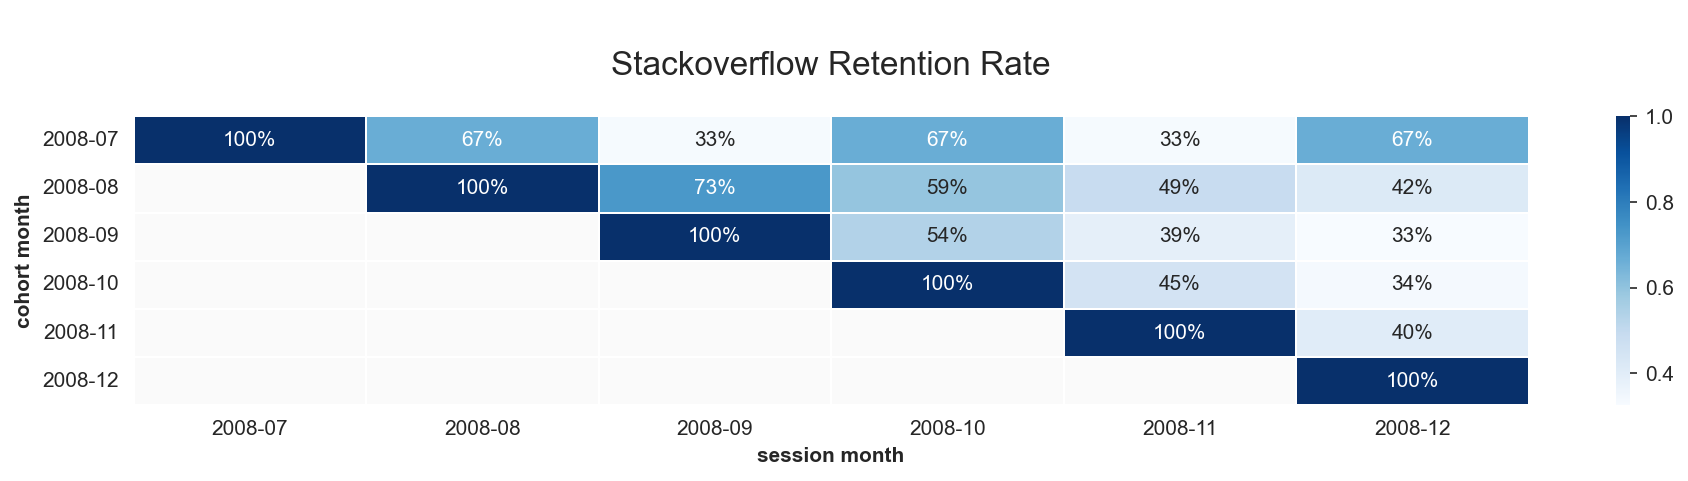

In [24]:
fig, ax = plt.subplots(figsize=(15, 0.5*df.shape[1]), dpi=PLOT_DPI)

sns.heatmap(
            retention,
            annot=True,
            annot_kws={'fontsize':10}, 
            fmt='0.0%',
            linewidths=0.2,
            cmap='Blues'
           )

plt.title('\nStackoverflow Retention Rate', pad=20)
ax.set_xlabel('session month')
ax.set_ylabel('cohort month')

plt.show() 

Когорта июля состоит всего из 3 человек, поэтому не подходит для анализа. Сентябрьская когорта самая многочисленная, но с большим падением активности, так же себя ведут меньшие по численности когорты октября и ноября. Вероятно, это массовая регистрация студентов в начале учебного года. Когорта августа с лучшей "выживаемостью" - пользователи больше и дольше вовлечены в работу.

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [25]:
# напишите запрос
query9 = '''
SELECT *,
      ROUND((post_count::numeric / LAG(post_count) OVER(ORDER BY creation_month) - 1) * 100, 2) AS percentage
FROM
(SELECT EXTRACT(MONTH FROM creation_date)::integer AS creation_month,
       COUNT(id) AS post_count
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-09-01' AND '2008-12-31'
GROUP BY EXTRACT(MONTH FROM creation_date)) AS pre_t
'''

sample_df9 = pd.read_sql_query(query9, con=engine)

In [26]:
sample_df9

,creation_month,post_count,percentage
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


<details>

<summary>Подсказка</summary>
Эту задачу стоит декомпозировать. Сформируйте запрос, который отобразит номер месяца и количество постов. Затем можно использовать оконную функцию, которая вернёт значение за предыдущий месяц, и посчитать процент.
</details>

Постройте круговую диаграмму с количеством постов по месяцам.

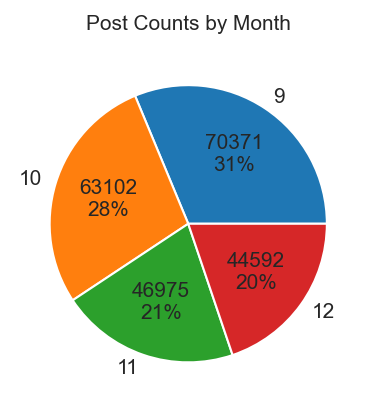

In [27]:
fig, ax = plt.subplots(figsize=(3,3), dpi=PLOT_DPI)

plt.pie(sample_df9.post_count, labels=sample_df9.creation_month, autopct=lambda p: f'{p*sum(sample_df9.post_count)/100 :.0f}\n{p :.0f}%')
plt.title('Post Counts by Month', fontsize=10)

plt.show()

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [28]:
# напишите запрос
query10 = '''
SELECT DISTINCT week_creation,
        MAX(creation_date) OVER(PARTITION BY week_creation)
FROM
(SELECT EXTRACT(WEEK FROM creation_date)::integer AS week_creation,
       creation_date
FROM stackoverflow.posts
WHERE user_id= (SELECT id
FROM
              (SELECT u.id AS id,
               COUNT(p.id) OVER(PARTITION BY p.user_id) AS c_p
FROM stackoverflow.users AS u
JOIN stackoverflow.posts AS p ON p.user_id=u.id
ORDER BY c_p DESC
LIMIT 1) AS pre_t1) 
AND DATE_TRUNC('month', creation_date) = '2008-10-01') AS pre_t2

'''

sample_df10 = pd.read_sql_query(query10, con=engine)

In [29]:
sample_df10

,week_creation,max
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01


<details>

<summary>Подсказка</summary>
Декомпозируйте задачу:
1) Найдите пользователя, который опубликовал больше всего постов. 2) Найдите дату и время создания каждого поста этого пользователя и номер недели. 
3) Отобразите данные только о последних постах пользователя. Для этого можно использовать оконную функцию.
</details>